In [1]:
import sys 
sys.path.append('../scripts/')
from dynamic_programming import *

In [2]:
class BeliefDynamicProgramming(DynamicProgramming): 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, puddle_coef=100.0, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): 
        super().__init__(widths, goal, puddles, time_interval, sampling_num, puddle_coef, lowerleft, upperright)
        
        self.index_nums = np.array([*self.index_nums, len(dev_borders) + 1])
        nx, ny, nt, nh = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt), range(nh)))
        
        self.value_function, self.final_state_flags =  self.init_belief_value_function()
        self.policy = np.zeros(np.r_[self.index_nums,2]) 
        
        self.dev_borders = dev_borders ###beliefdp3（calc_motion_sigma_transition_probsまで） #以下追加
        self.dev_borders_side = [dev_borders[0]/10, *dev_borders, dev_borders[-1]*10] #dev_bordersに両側を加える
        self.motion_sigma_transition_probs = self.init_motion_sigma_transition_probs()
        
    def init_motion_sigma_transition_probs(self):
        probs = {}
        for a in self.actions:
            for i in range(len(self.dev_borders)+1):
                probs[(i, a)] = self.calc_motion_sigma_transition_probs(self.dev_borders_side[i], self.dev_borders_side[i+1], a)
                
        return probs
            
    def cov_to_index(self, cov):
        sigma = np.power(np.linalg.det(cov), 1.0/6)
        for i, e in enumerate(self.dev_borders):
            if sigma < e: return i
            
        return len(self.dev_borders)
        
    def calc_motion_sigma_transition_probs(self, min_sigma, max_sigma, action, sampling_num=100):
        nu, omega = action
        if abs(omega) < 1e-5: omega = 1e-5

        F = matF(nu, omega, self.time_interval, 0.0) #ロボットの向きは関係ないので0[deg]で固定で
        M = matM(nu, omega, self.time_interval, {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2})#移動の誤差モデル（カルマンフィルタのものをコピペ）
        A = matA(nu, omega, self.time_interval, 0.0)
        
        ans = {}
        for sigma in np.linspace(min_sigma, max_sigma*0.999, sampling_num): #遷移前のσを作る（区間内に一様分布していると仮定）
            index_after = self.cov_to_index(sigma*sigma*F.dot(F.T) + A.dot(M).dot(A.T)) #遷移後のσのインデックス
            ans[index_after] = 1 if index_after not in ans else ans[index_after] + 1 #単にカウントしてるだけ（辞書の初期化もあるのでややこしい）
                
        for e in ans:
            ans[e] /= sampling_num #頻度を確率に

        return ans
    
    def init_belief_value_function(self): 
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.belief_final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def belief_final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index[0:3] 
        x_max, y_max, _ = self.pose_min + self.widths*(index[0:3] + 1) 
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] 
        return all([self.goal.inside(np.array(c).T) for c in corners ]) and index[3] == 0
    
    def action_value(self, action, index, out_penalty=True):  ###beliefdp4
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:
            after, out_reward = self.out_correction(np.array(index[0:3]).T + delta)
        
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            for sigma_after, sigma_prob in self.motion_sigma_transition_probs[(index[3], action)].items(): #hの遷移先ごとに処理
                value += (self.value_function[tuple([*after, sigma_after])] + reward) * prob * sigma_prob  #インデックスを拡張し、確率をかける

        return value

In [3]:
puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)]
dp = BeliefDynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10)  

<IPython.core.display.Javascript object>


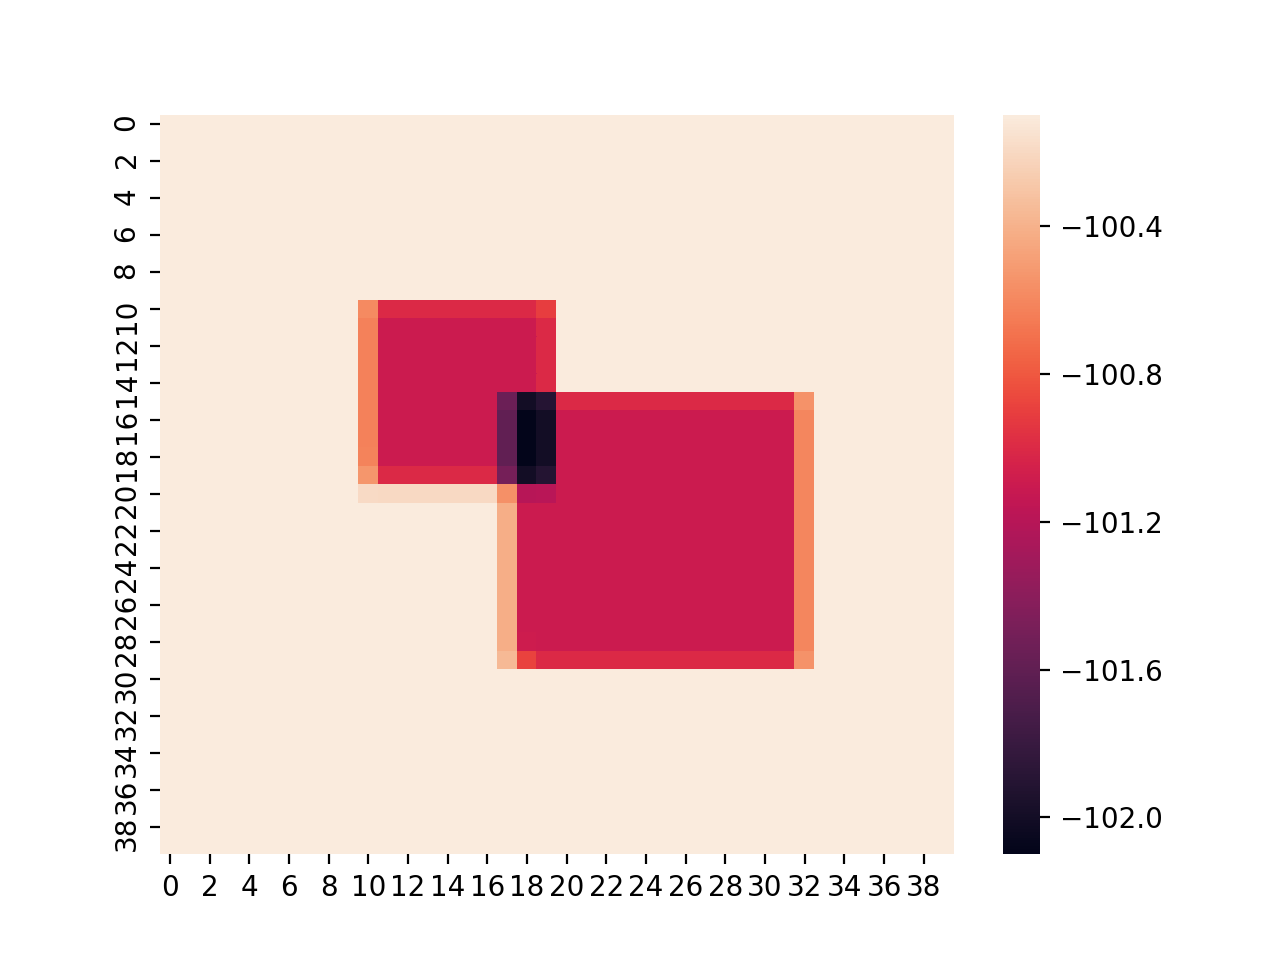

<IPython.core.display.Javascript object>


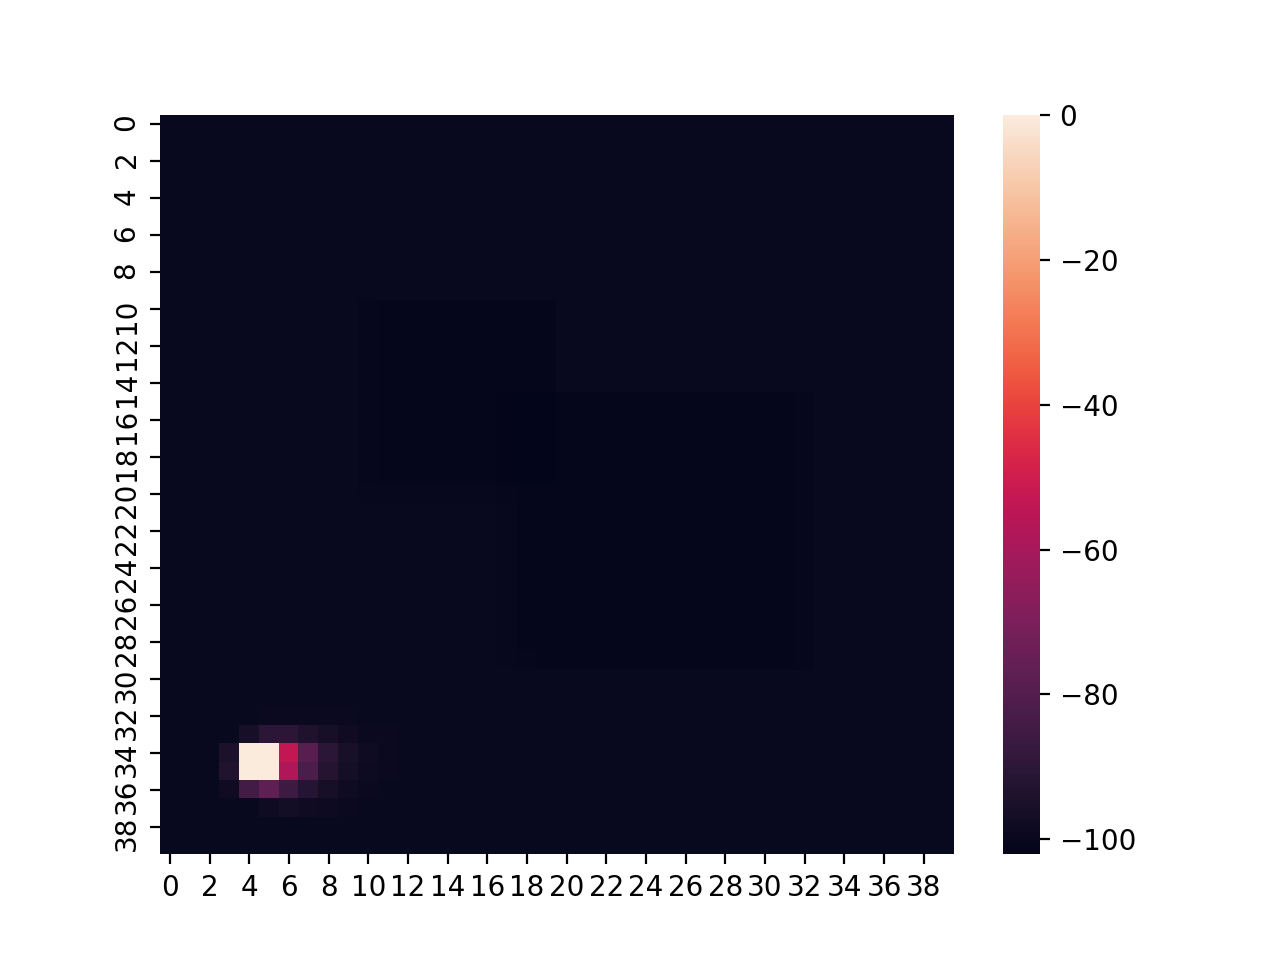

In [4]:
delta = dp.value_iteration_sweep() ###amdp4sweep
import seaborn as sns
v = dp.value_function[:, :, 18, 1] #σのインデックスが1だと終端状態にはたどり着けないので価値は改善しない
sns.heatmap(np.rot90(v), square=False)
plt.show()
v = dp.value_function[:, :, 18, 0] #σのインデックスが0だと改善する
sns.heatmap(np.rot90(v), square=False)
plt.show()